In [1]:
import os,sys,string, time
import ROOT
from math import *
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from root_pandas import read_root
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
import pickle

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables

print ('Success')

Welcome to JupyROOT 6.24/06
Success


# Loading in the "results" dataframe after full selection

In [2]:
Run = "run1" #so far either "run1" or "run3"

HNL_masses = Constants.HNL_mass_samples

loc_pkl = f'pkl_files/{Run}/current_files/Results/'

overlay_results = pd.read_pickle(loc_pkl+"overlay_test1.pkl") #This will contain all of the BDT output scores

# Reading in the overlay .root file with reweight branches

In [3]:
sys_variables = Variables.sys_vars + Variables.event_vars + Variables.weight_related

if Run == "run1":
    NuMI_MC_overlay = uproot3.open('../NuMI_MC/SLIMMED_neutrinoselection_filt_run1_overlay.root')['nuselection/NeutrinoSelectionFilter']
elif Run == "run3":
    NuMI_MC_overlay = uproot3.open('../NuMI_MC/SLIMMED_neutrinoselection_filt_run3b_overlay.root')['nuselection/NeutrinoSelectionFilter']

df_overlay_weights = NuMI_MC_overlay.pandas.df(sys_variables, flatten=False) #Perhaps I can do this in a more clever way than just making a dataframe


# Keeping only the events which pass selection in the weight dataframe

In [24]:
def make_unique_ev_id(df): #df must have 'run', 'sub' and 'evt' branches
    if pd.Series(['run', 'sub', 'evt']).isin(df.columns).all():
        rse_list = []
        for entry in df.index: #Looping over all events in the dataframe
            rse = str(df['run'][entry]) + "_" + str(df['sub'][entry]) + "_" + str(df['evt'][entry])
            rse_list.append(rse)
        df['rse_id'] = rse_list #Writing a new branch with the unique event id
        return df.copy()
    else:
        print("Dataframe needs \"run\", \"sub\" and \"evt\" columns.")
        return 0
    
def check_duplicate_events(df):
    rse_list = df['rse_id'].to_list()

    seen = set()
    dupes = []

    for x in rse_list:
        if x in seen:
            dupes.append(x)
        else:
            seen.add(x)
    print("Number of duplicates is " + str(len(dupes)))
    print("Number of unique events is " + str(len(seen)))

    
overlay_rse = make_unique_ev_id(overlay_results)
df_overlay_weights_rse = make_unique_ev_id(df_overlay_weights)

#Deleting any duplicates of events, should be able to avoid if correctly filtered for one event per row
overlay_rse.drop_duplicates(subset=['rse_id'], keep='first', inplace=True)

print("Number of events in weights file is " + str(len(df_overlay_weights_rse)))
print("Number of events in results file is " + str(len(overlay_rse)))

Index(['weightsPPFX', 'weightsGenie', 'weightsReint', 'run', 'sub', 'evt',
       'weightSplineTimesTune', 'ppfx_cv', 'npi0', 'rse_id'],
      dtype='object')


In [27]:
#Keeping only those events in the final selection
filtered_weights = df_overlay_weights_rse.loc[(df_overlay_weights_rse['rse_id'].isin(overlay_rse['rse_id']))]

print("Number of events in the filtered weights file is " + str(len(filtered_weights)))
print("Number of events in results file is " + str(len(overlay_rse)))

33763
33490


## Merging into one dataframe with results and weights

In [74]:
BDT_score_list = []

for HNL_mass in HNL_masses:
    BDT_score_list.append(f'BDT_output_{HNL_mass}MeV')

just_score_df = overlay_rse[BDT_score_list + ['rse_id','weight']].copy()

print(just_score_df.keys())

final_merged = pd.merge(filtered_weights,just_score_df, how='outer', on=['rse_id']) #This will have the reweighting branches AND BDT score branches

print(final_merged.keys())
# print(len(final_merged))

# df2 = final_merged.loc[:,~final_merged.columns.duplicated()] #If "weight" column is duplicated, this removes one of them

# print(df2.keys())
# print(len(df2))


Index(['run', 'sub', 'evt', 'weightSplineTimesTune', 'ppfx_cv', 'npi0',
       'weight', 'weight', 'BDT_output_20MeV', 'BDT_output_50MeV',
       'BDT_output_100MeV', 'BDT_output_150MeV', 'BDT_output_180MeV',
       'BDT_output_200MeV', 'rse_id'],
      dtype='object')
Index(['weightsPPFX', 'weightsGenie', 'weightsReint', 'run', 'sub', 'evt',
       'weightSplineTimesTune', 'ppfx_cv', 'npi0', 'rse_id'],
      dtype='object')
33490
33490
Index(['BDT_output_20MeV', 'BDT_output_50MeV', 'BDT_output_100MeV',
       'BDT_output_150MeV', 'BDT_output_180MeV', 'BDT_output_200MeV', 'rse_id',
       'weight', 'weight'],
      dtype='object')
33490
Index(['weightsPPFX', 'weightsGenie', 'weightsReint', 'run', 'sub', 'evt',
       'weightSplineTimesTune', 'ppfx_cv', 'npi0', 'rse_id',
       'BDT_output_20MeV', 'BDT_output_50MeV', 'BDT_output_100MeV',
       'BDT_output_150MeV', 'BDT_output_180MeV', 'BDT_output_200MeV', 'weight',
       'weight'],
      dtype='object')
33490
Index(['weightsPPFX', 'we

# Plotting the BDT score with all different multisims

In [71]:
def sys_err(sample, name, var_name, x_range, bins,NormScale): #This only does one at a time, would be nice to have a function which does all 3
    # how many universes?
    Nuniverse = Constants.Multisim_univs[name] 

    if(isinstance(bins, int)):n_bins=bins
    else: n_bins=len(bins)-1

    
    n_tot = np.empty([Nuniverse, n_bins])
    n_cv_tot = np.empty(n_bins)
    n_tot.fill(0)
    n_cv_tot.fill(0)

    variable = sample[var_name]
    syst_weights = sample[name]
    #print ('N universes is :',len(syst_weights))
    spline_fix_cv  = sample["weight"]*NormScale
    spline_fix_var = sample["weight"]*NormScale
#     if (name == "weightsGenie"): 
#         spline_fix_var = queried_sample["ppfx_cv"]*NormScale

    s = syst_weights
    df = pd.DataFrame(s.values.tolist())
    #print (df)
    #continue
    n_cv, bins = np.histogram(
        variable,
        range=x_range,
        bins=bins,
        weights=spline_fix_cv)
    n_cv_tot += n_cv
    
    if(name == "weightsGenie"): #special treatment as ["weightSplineTimesTune"] is included in genie weights
        if not df.empty:
            for i in range(Nuniverse):
                weight = df[i].values / 1000.
                weight[weight == 1]= sample["weightSplineTimesTune"].iloc[weight == 1]
                weight[np.isnan(weight)] = sample["weightSplineTimesTune"].iloc[np.isnan(weight)]
                weight[weight > 30] = sample["weightSplineTimesTune"].iloc[weight > 30] #build up of events at 65 weight 
                weight[weight < 0] = sample["weightSplineTimesTune"].iloc[weight < 0] 
                weight[weight == np.inf] = sample["weightSplineTimesTune"].iloc[weight == np.inf]
                
                n, bins = np.histogram(
                    variable, weights=weight*np.nan_to_num(spline_fix_var/sample["weightSplineTimesTune"]), range=x_range, bins=bins)
                n_tot[i] += n
                
    elif(name == "weightsPPFX"): #special treatment as ["PPFXPcv"] is included in ppfx weights
        if not df.empty:
            for i in range(Nuniverse):
                weight = df[i].values / 1000.
                weight[weight == 1]= sample["ppfx_cv"].iloc[weight == 1]
                weight[np.isnan(weight)] = sample["ppfx_cv"].iloc[np.isnan(weight)]
                weight[weight > 100] = sample["ppfx_cv"].iloc[weight > 100]
                weight[weight < 0] = sample["ppfx_cv"].iloc[weight < 0]
                weight[weight == np.inf] = sample["ppfx_cv"].iloc[weight == np.inf]
                
                n, bins = np.histogram(
                    variable, weights=weight*np.nan_to_num(spline_fix_var/sample["ppfx_cv"]), range=x_range, bins=bins)
                n_tot[i] += n
    else:       
        if not df.empty:
            for i in range(Nuniverse):
                weight = df[i].values / 1000.
                weight[np.isnan(weight)] = 1
                weight[weight > 100] = 1
                weight[weight < 0] = 1
                weight[weight == np.inf] = 1
                n, bins = np.histogram(
                    variable, weights=weight*spline_fix_var, range=x_range, bins=bins)
                n_tot[i] += n

    cov = np.empty([len(n_cv), len(n_cv)])
    cov.fill(0)

#     print()
#     bin1s=[]
    for n in n_tot:
#         print(n/2)
#         bin1s.append(n[2])
        for i in range(len(n_cv)):
            for j in range(len(n_cv)):
                cov[i][j] += (n[i] - n_cv_tot[i]) * (n[j] - n_cv_tot[j])


    cov /= Nuniverse
#     print(np.sqrt(np.diag(cov))/n_cv)
    return cov,n_cv_tot,n_tot,bins
  


In [76]:
cov_ppfx,cv,n_tot_ppfx,bins=sys_err(df2,"weightsPPFX",'BDT_output_20MeV',[0,1.0],20,Constants.SF_overlay_run1)

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


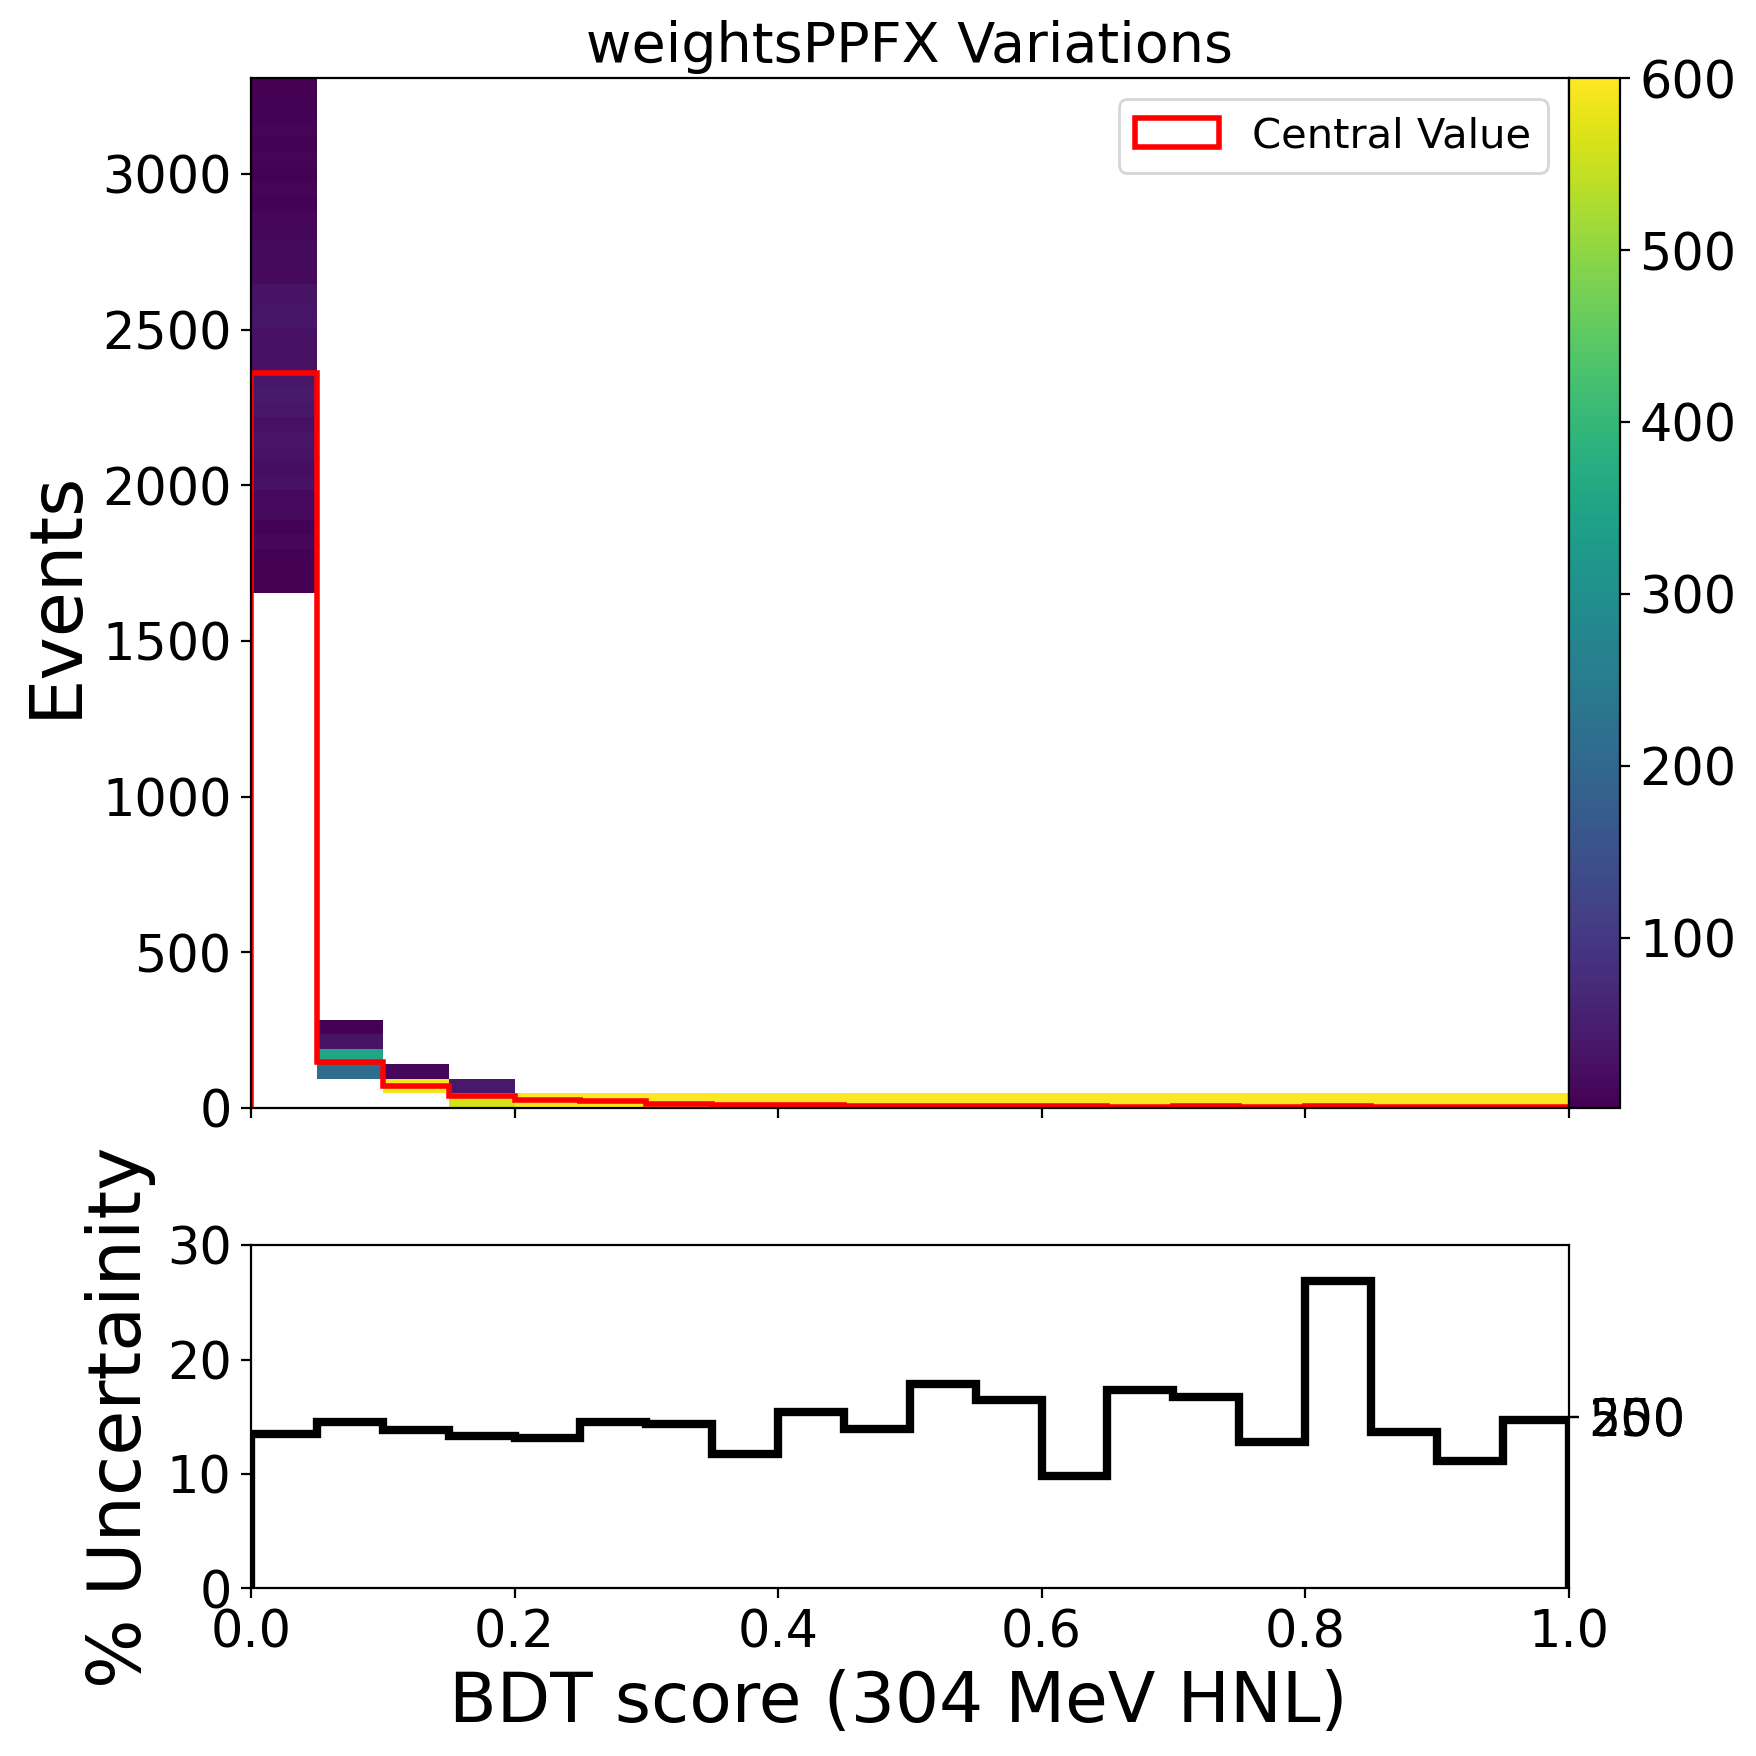

In [92]:
figsize=[10,10]
dpi=200
fig,ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=figsize,dpi=dpi)
plt.sca(ax[0])

bins=np.linspace(0,1.0,21)

print(bins)
bins_cent=(bins[:-1]+bins[1:])/2
bins_centlong=np.tile(bins_cent,600)

nybins=70

plt.title("weightsPPFX Variations",fontsize=20)

plt.hist(bins_cent,bins,weights=cv,color="red",histtype="step",label="Central Value",lw=2,linestyle='-')
plt.legend()
bins_cent=(bins[:-1]+bins[1:])/2
bins_centlong=np.tile(bins_cent,600)
# plt.step(bins_cent,cv+np.sqrt(np.diag(cov_gen)),lw=4,color="orange",ls="--")
# plt.step(bins_cent,cv-np.sqrt(np.diag(cov_gen)),lw=4,color="orange",ls="--")
# plt.colorbar()



plt.ylabel("Events")
plt.hist2d(bins_centlong,n_tot_ppfx.flatten(),bins=[bins,nybins],cmin=1,range=[[0,1.0],[0,max(cv)*1.4]],rasterized=True)
# cbaxes = inset_axes(ax[0], width="3%", height="50%", loc="right") 

# cbaxes = inset_axes(ax[0],[0.8, 0.1, 0.15, 0.15])
plt.colorbar(pad=0,use_gridspec=True)
# plt.yscale("log")
plt.ylim(0,max(cv)*1.4)
# plt.yscale("log")

plt.sca(ax[1])

# plt.step(bins_cent,np.sqrt(np.diag(cov_gen))/cv*100,color="black",where="mid")
plt.hist(bins_cent,bins,weights=np.sqrt(np.diag(cov_ppfx))/cv*100,color="black",histtype="step",lw=3,linestyle='-')
plt.ylim(0,30)
plt.ylabel("% Uncertainity")
plt.xlabel("BDT score (20 MeV HNL) ",fontsize=25)

cbar=plt.colorbar(shrink=0,pad=0,ticks=None) #Lol

In [101]:
ppfx_unc = np.sqrt(np.diag(cov_ppfx))

print(type(ppfx_unc))
print(len(ppfx_unc))
print(ppfx_unc)

<class 'numpy.ndarray'>
20
[319.72096369  21.61622832   9.74294834   5.16770066   3.22093156
   3.14625288   2.03972364   1.28068359   1.5632839    0.96213792
   1.15011802   0.91606067   0.57898486   0.73305165   0.80049515
   0.45597716   1.57518151   0.44148673   0.43920199   0.37961015]


## Saving reweighting uncertainties as .root files

In [99]:
def SaveToRoot(nbins,xlims,uncertainty,name,fileName='test.root'):
    nBins = nbins
    binLimits = xlims
  ### Save files 
    rFile = ROOT.TFile(f'Uncertainties/{fileName}','RECREATE')
    tData1 = ROOT.TH1F(name,name,nBins,binLimits[0],binLimits[1])
    for i in range(nBins):
        tData1.SetBinContent(i+1,uncertainty[i])
    rFile.Write()
    rFile.Close()
    


In [100]:
HNL_mass = 20
SaveToRoot(20,[0,1.0],ppfx_unc,'ppfx_uncertainty',fileName=f'Test_1_{HNL_mass}MeV.root')